In [22]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
data_path = Path('/Users/pengshuoliu/abstraction-and-reasoning-challenge')
train_path = data_path / 'training'
eval_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [17]:
train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() }
eval_tasks = { task.stem: json.load(task.open()) for task in eval_path.iterdir() }
test_tasks = { task.stem: json.load(task.open()) for task in test_path.iterdir() }

In [3]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()

In [ ]:
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

In [ ]:
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

In [ ]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

In [ ]:
def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [4]:
HIDDEN_SIZE = 128
MAX_STEPS = 10
THRESHOLD = 0.99
REMAINDERS_PEN = 0.0
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv2d(num_states, HIDDEN_SIZE, kernel_size=1),
            nn.InstanceNorm2d(HIDDEN_SIZE),
        )
        self.transition = nn.Sequential(
            nn.InstanceNorm2d(HIDDEN_SIZE),
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE, kernel_size=1, padding=0),
        )
        self.projection_out = nn.Conv2d(HIDDEN_SIZE, num_states, kernel_size=1)
        self.projection_halt = nn.Conv2d(HIDDEN_SIZE, 1, kernel_size=1)
        
    def forward(self, x, max_steps=None):
        x = self.embedding(x)
        halting_probability = torch.zeros([1, 1, x.shape[2], x.shape[3]], device=x.device)
        remainders = torch.zeros([1, 1, x.shape[2], x.shape[3]], device=x.device)
        n_updates = torch.zeros([1, 1, x.shape[2], x.shape[3]], device=x.device)
        max_steps = max_steps or MAX_STEPS
        for i in range(max_steps):
            p = torch.sigmoid(self.projection_halt(x) - 1)
            still_running = (halting_probability <= THRESHOLD).to(torch.float)
            new_halted = ((halting_probability + p * still_running) > THRESHOLD).to(torch.float) * still_running
            still_running = ((halting_probability + p * still_running) <= THRESHOLD).to(torch.float) * still_running
            halting_probability += p * still_running
            remainders += new_halted * (1 - halting_probability)
            halting_probability += new_halted * remainders
            n_updates += still_running + new_halted
            update_weights = p * still_running + new_halted * remainders
            transformed_state = self.transition(x)
            x = transformed_state * update_weights + x * (1 - update_weights)
            if still_running.sum() == 0:
                break
        
        x = self.projection_out(x)
        self._remainders = remainders
        self._n_updates = n_updates
        return x

In [5]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros(num_epochs)
    n_updates = np.zeros(num_epochs)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = 0.0
        
        for sample in task:
            # predict output from input
            x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
            y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
            y_pred = model(x)
            loss += criterion(y_pred, y) + (model._remainders * REMAINDERS_PEN).mean(0).sum()
            n_updates[e] += model._n_updates.detach().cpu().mean().numpy() / len(task)
        
        loss.backward()
        optimizer.step()
        losses[e] = loss.item()
    return model, losses, n_updates

In [ ]:
@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions

model:
 CAModel(
  (embedding): Sequential(
    (0): Conv2d(10, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (transition): Sequential(
    (0): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection_out): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  (projection_halt): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)
n_updates [4.06785715 4.23035705 4.54464293 4.58749986 4.59642839 4.6107142
 4.64285731 4.65178585 4.52142859 4.37857151 4.26964307 4.10714293
 4.00535727 3.96785712 4.05535698 4.1624999  4.30178571 4.47142839
 4.64642859 4.69285703 4.71607137 4.77678585 4.82142854 4.87321424
 4.9375     5.0625     5.08928561 5.08928561 5.13571429 5.11785698
 5.10892844 5.05535698 5.032

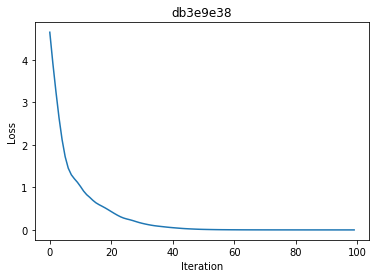

In [29]:
task = train_tasks["db3e9e38"]["train"]
model, losses, n_updates = solve_task(task)
print('model:\n', model)
print('n_updates', n_updates)
print(f"Last loss: {losses[-1]:.5f}")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('db3e9e38')
plt.plot(losses)

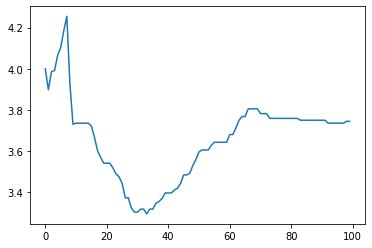

In [7]:
plt.plot(n_updates)

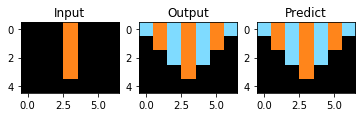

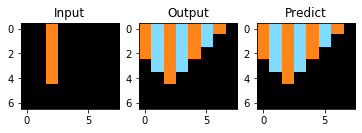

In [8]:
predictions = predict(model, task)
for i in range(len(task)):
    plot_sample(task[i], predictions[i])

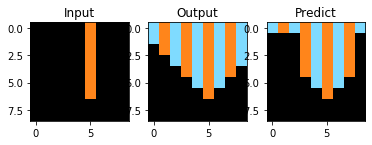

In [9]:
test = train_tasks["db3e9e38"]["test"]
predictions = predict(model, test)
for i in range(len(test)):
    plot_sample(test[i], predictions[i])

In [11]:
def evaluate(tasks, is_test=False):
    result = []
    predictions = {}
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"])
            pred = predict(model, task["test"])
            if not is_test:
                score = calk_score(task["test"], pred)
            else:
                score = [0] * len(task["test"])
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions[idx] = pred
        result.append(score)
    return result, predictions

In [12]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [1:31:49<00:00, 13.77s/it]

solved : 24 from 416 (0.057692307692307696)


0it [00:00, ?it/s]

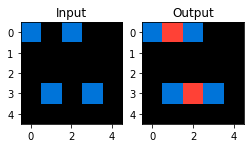

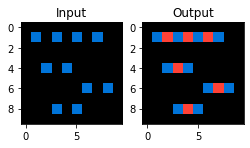

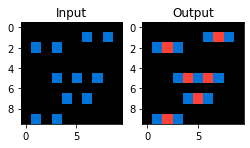

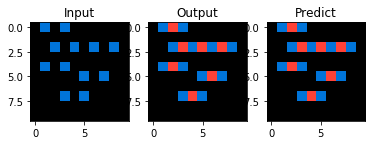

4it [00:01,  3.77it/s]

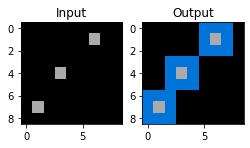

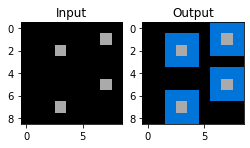

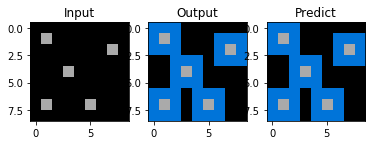

10it [00:01,  4.53it/s]

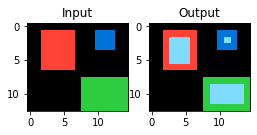

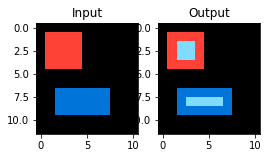

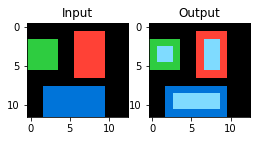

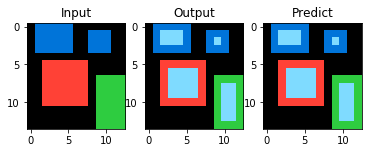

23it [00:03,  5.39it/s]

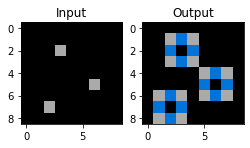

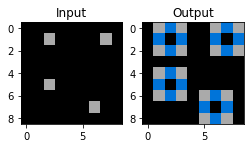

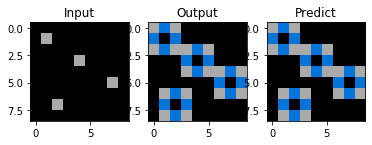

49it [00:03,  7.26it/s]

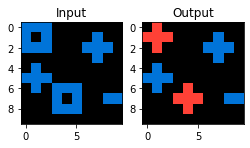

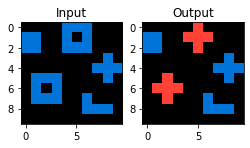

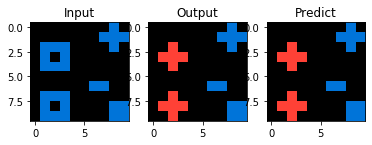

51it [00:04,  5.08it/s]

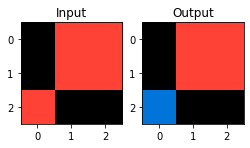

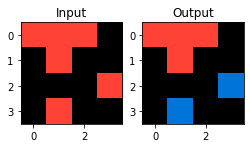

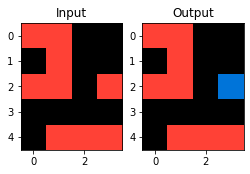

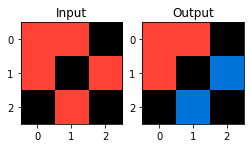

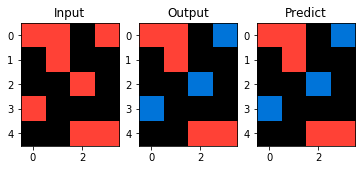

55it [00:05,  4.44it/s]

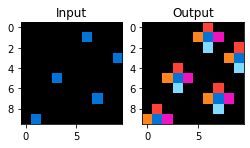

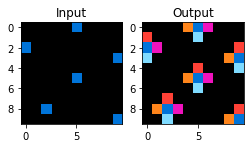

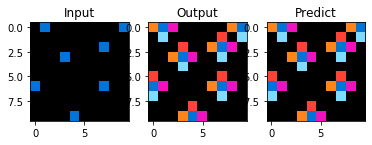

65it [00:06,  5.60it/s]

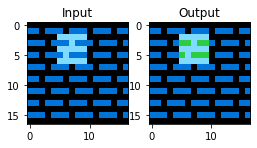

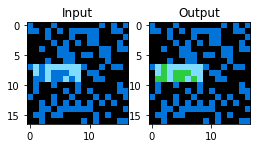

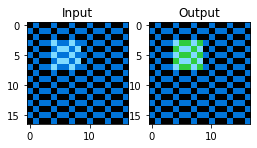

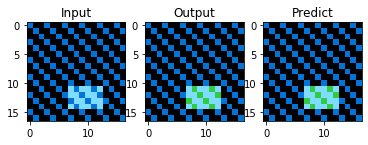

73it [00:07,  6.30it/s]

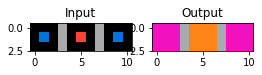

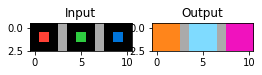

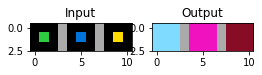

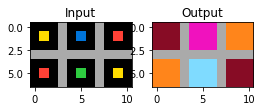

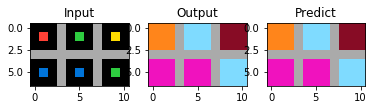

77it [00:08,  5.09it/s]

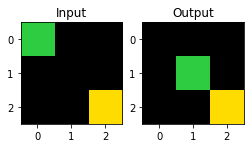

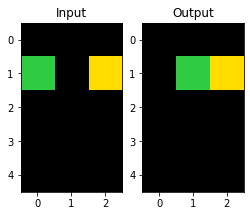

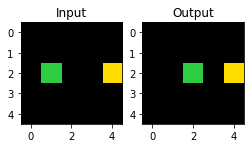

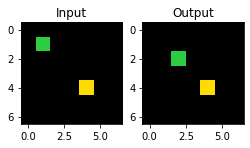

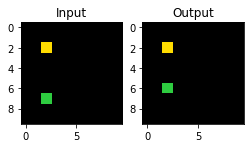

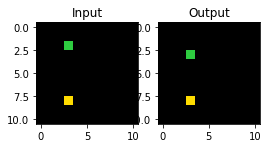

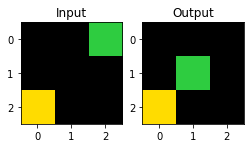

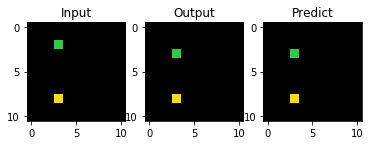

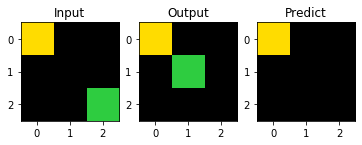

136it [00:10,  6.73it/s]

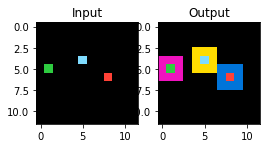

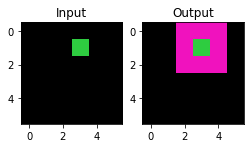

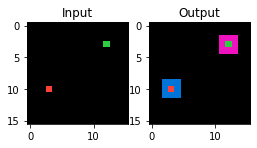

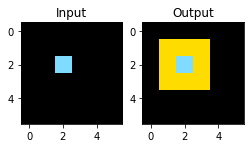

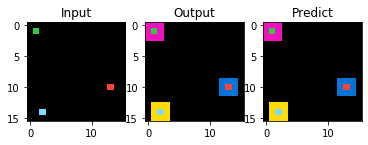

144it [00:11,  6.94it/s]

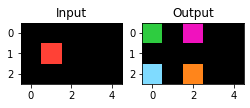

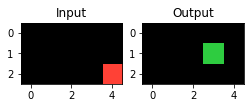

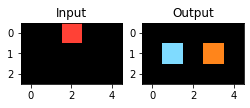

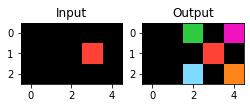

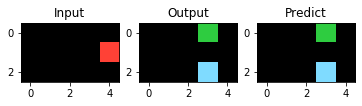

166it [00:12,  8.60it/s]

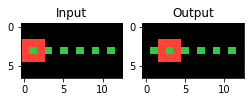

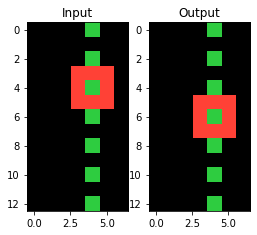

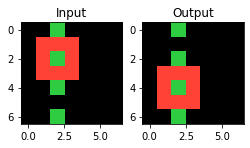

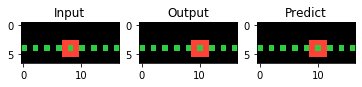

184it [00:13, 10.42it/s]

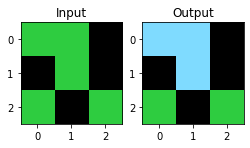

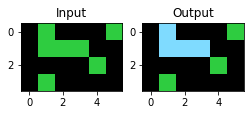

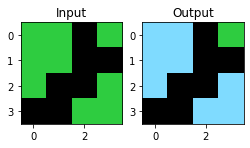

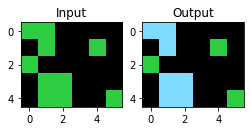

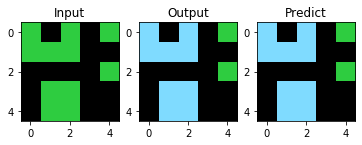

195it [00:14, 10.39it/s]

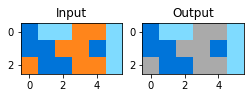

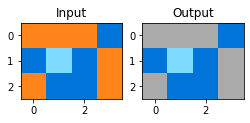

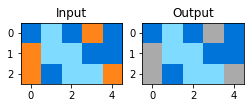

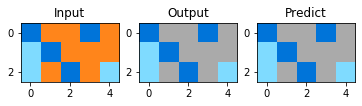

226it [00:15, 13.09it/s]

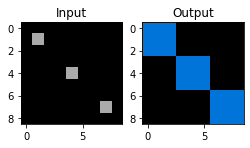

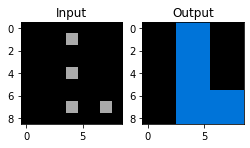

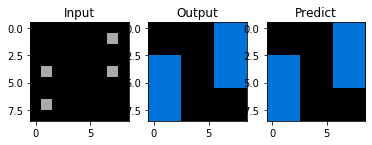

233it [00:16, 11.95it/s]

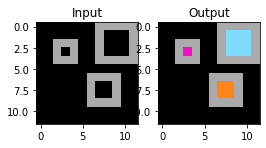

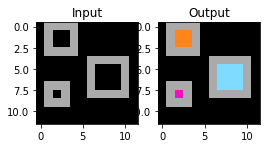

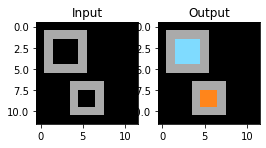

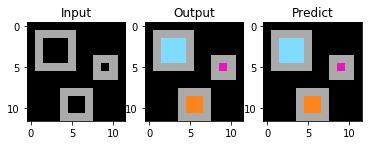

241it [00:17, 10.94it/s]

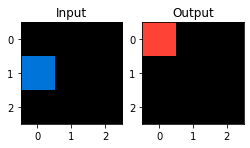

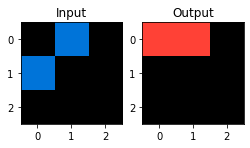

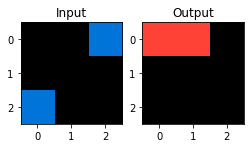

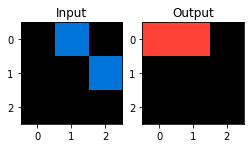

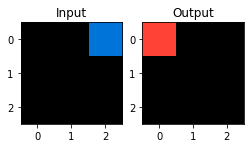

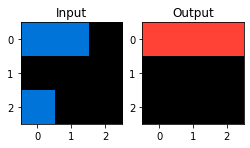

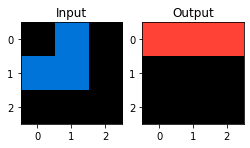

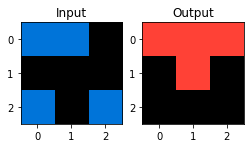

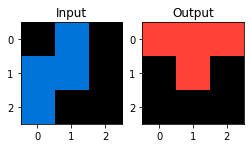

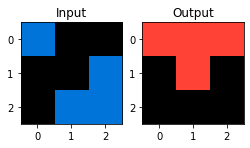

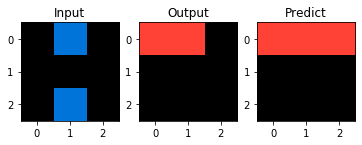

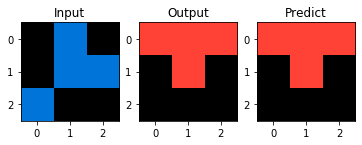

272it [00:19, 11.26it/s]

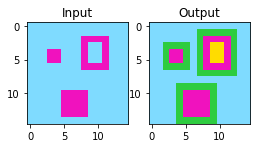

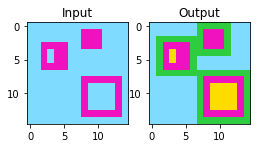

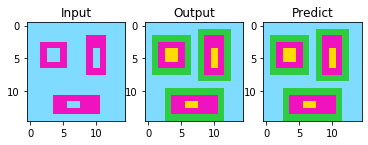

284it [00:20, 12.25it/s]

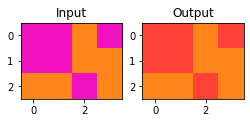

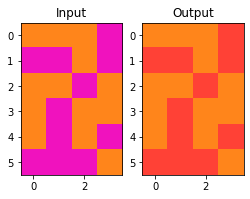

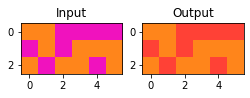

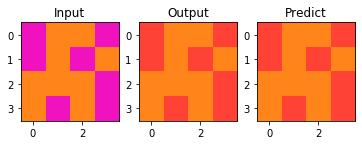

289it [00:21,  9.08it/s]

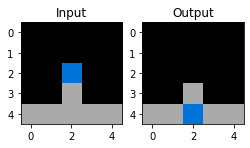

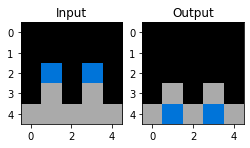

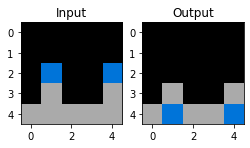

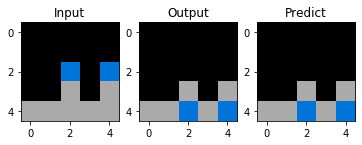

292it [00:22,  6.03it/s]

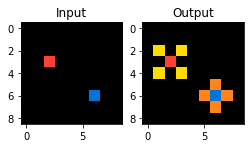

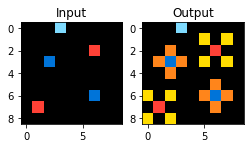

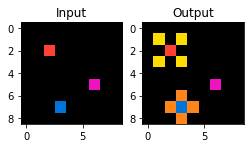

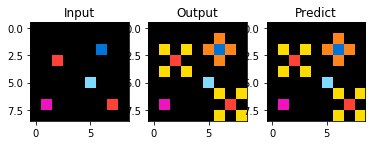

307it [00:23,  7.38it/s]

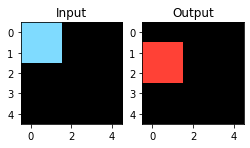

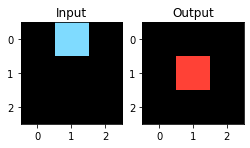

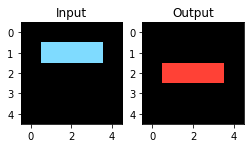

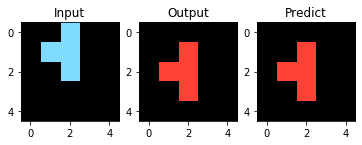

344it [00:24,  9.82it/s]

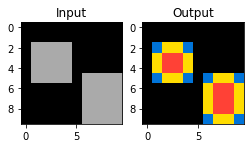

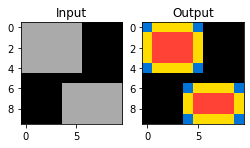

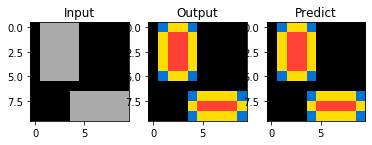

400it [00:24, 16.10it/s]


In [15]:
for task, prediction, solved in tqdm(zip(train_tasks.values(), train_predictions.values(), train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

In [13]:
eval_result, eval_predictions = evaluate(eval_tasks)
eval_solved = [any(score) for score in eval_result]

total_eval = sum([len(score) for score in eval_result])
print(f"Eval: solved : {sum(eval_solved)} from {total_eval} ({sum(eval_solved)/total})")

100%|██████████| 400/400 [2:01:02<00:00, 18.16s/it]  

Eval: solved : 3 from 419 (0.007211538461538462)


0it [00:00, ?it/s]

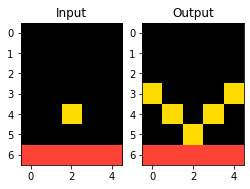

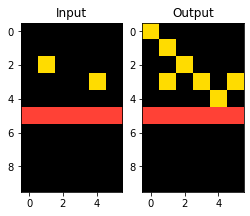

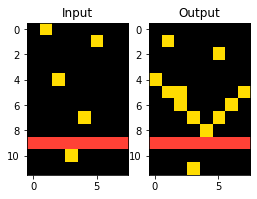

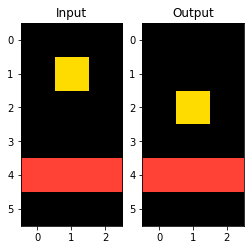

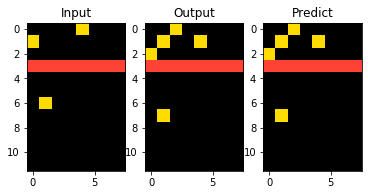

80it [00:01, 47.43it/s]

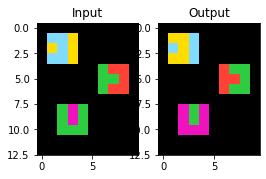

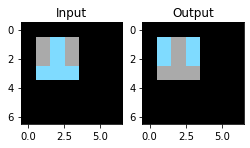

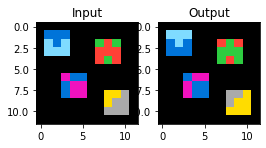

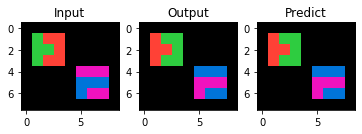

101it [00:03, 26.88it/s]

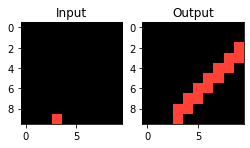

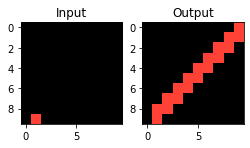

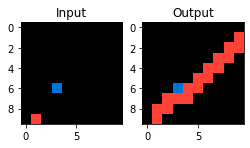

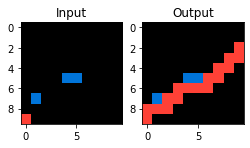

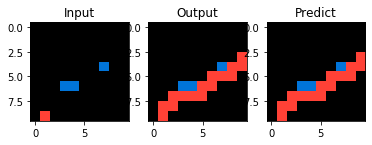

400it [00:05, 79.95it/s]


In [21]:
for task, prediction, solved in tqdm(zip(eval_tasks.values(), eval_predictions.values(), eval_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

In [14]:
test_result, test_predictions = evaluate(test_tasks, is_test=True)

100%|██████████| 100/100 [26:15<00:00, 15.76s/it]


In [23]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...

In [19]:
def flattener(pred):
    str_pred = str([list(row) for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [20]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    data = test_predictions[task_id][pair_id]
    pred_1 = flattener(data)
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission_ca_cnn_act.csv')
submission.head()

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000222222222|00000200020202|...
00dbd492_0  |00333333340222220000|02222222220288820000|023...
03560426_0  |1880000000|8880000000|8870000000|8872000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002820...